In [22]:
!pip install hvplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hvplot.pandas
from scipy import stats

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
data = pd.read_csv("/content/drive/MyDrive/Enseignement/ISET/Articles/Article 3/Code/stress3.csv")
data.head()

,spo2,bpm,sweat,status
0,91,96,308,0
1,95,99,360,1
2,93,102,245,2
3,95,89,215,2
4,89,99,324,2


In [26]:
categorical_val = []
continous_val = []
for column in data.columns:
    if len(data[column].unique()) <= 10:
        categorical_val.append(column)
    else:
        continous_val.append(column)

# 🔄 Data Processing

After exploring the dataset, I observed that I need to convert some categorical variables into dummy variables and scale all the values before training the Machine Learning models.
First, I'll use the `get_dummies` method to create dummy columns for categorical variables.

In [27]:
#categorical_val.remove('target')
#dataset = pd.get_dummies(data, columns = categorical_val)

In [28]:
dataset=data
dataset.head()

,spo2,bpm,sweat,status
0,91,96,308,0
1,95,99,360,1
2,93,102,245,2
3,95,89,215,2
4,89,99,324,2


In [29]:
from sklearn.preprocessing import StandardScaler

s_sc = StandardScaler()
col_to_scale = ['spo2', 'bpm', 'sweat']
dataset[col_to_scale] = s_sc.fit_transform(dataset[col_to_scale])

In [30]:
dataset.head()

,spo2,bpm,sweat,status
0,-0.073197,0.088803,0.336946,0
1,0.600218,0.212242,1.103703,1
2,0.263510,0.335681,-0.592010,2
3,0.600218,-0.199221,-1.034370,2
4,-0.409905,0.212242,0.572871,2


# 🤖 Models Building

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

def matrice(preds, y_test, title):
    cf_matrix = confusion_matrix(y_test, preds)
    print(cf_matrix)

    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    ax.set_title(title);
    ax.set_xlabel('\nPredicted class')
    ax.set_ylabel('Actual class');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['No\nStress','Low\nStress','High\nStress'])
    ax.yaxis.set_ticklabels(['No\nStress','Low\nStress','High\nStress'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [32]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import classification_report

def print_score(preds, y_test):
    #clf_report = pd.DataFrame(classification_report(y_test, preds, output_dict=True))
    print("Test Result:\n================================================")        
    print(f"Accuracy Score: {accuracy_score(y_test, preds) * 100:.2f}%")
    print(f"F1 Score: {f1_score(y_test, preds, average='weighted') * 100:.2f}%")
    print(f"MCC Score: {matthews_corrcoef(y_test, preds) * 100:.2f}%")
    print(f"Precision: {precision_score(y_test, preds, average='weighted') * 100:.2f}%")
    print(f"Recall: {recall_score(y_test, preds, average='weighted') * 100:.2f}%")
    #print("\nDetails:\n================================================")    
    #target_names = ['No Stress','Low Stress','High Stress']
    #print(classification_report(y_test, preds, target_names=target_names, digits=4))

In [33]:
from sklearn.model_selection import train_test_split

X = dataset.drop('status', axis=1)
y = dataset.status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
import pickle
path= "/content/drive/MyDrive/Enseignement/ISET/Articles/Article 3/Code/Models/" 
RF_HOLDOUT_path = path+"Holdout/RF_Holdout_model.pickle" 
SVM_CV3_path = path+"CV3/SVM_CV3_model.pickle" 
DT_CV5_path = path+"CV5/TREE_CV5_model.pickle" 
SVM_CV7_path = path+"CV7/SVM_CV7_model.pickle" 
RF_CV10_path = path+"CV10/RF_CV10_model.pickle" 
# load model
RF_HOLDOUT_clf = pickle.load(open(RF_HOLDOUT_path, "rb"))
SVM_CV3_clf = pickle.load(open(SVM_CV3_path, "rb"))
DT_CV5_clf = pickle.load(open(DT_CV5_path, "rb"))
SVM_CV7_clf = pickle.load(open(SVM_CV7_path, "rb"))
RF_CV10_clf = pickle.load(open(RF_CV10_path, "rb"))

## Voting\Stacking Classification Example

In [35]:
from sklearn.ensemble import VotingClassifier
hard_voting_clf = VotingClassifier(estimators=[('RF_HOLDOUT', RF_HOLDOUT_clf), ('SVM_CV3', SVM_CV3_clf), ('DT_CV5', DT_CV5_clf), ('SVM_CV7', SVM_CV7_clf), ('RF_CV10', RF_CV10_clf)], voting='hard')
hard_voting_clf.fit(X_train, y_train)
hard_preds = hard_voting_clf.predict(X_test)

In [36]:
print_score(hard_preds, y_test)

Test Result:
Accuracy Score: 76.87%
F1 Score: 76.74%
MCC Score: 65.39%
Precision: 79.17%
Recall: 76.87%


In [37]:
from sklearn.ensemble import VotingClassifier
soft_voting_clf = VotingClassifier(estimators=[('RF_HOLDOUT', RF_HOLDOUT_clf), ('SVM_CVM', SVM_CV3_clf), ('DT_CV5', DT_CV5_clf), ('SVM_CV7', SVM_CV7_clf), ('RF_CV10', RF_CV10_clf)], voting='soft', weights=[1,1,1,1,2])
soft_voting_clf.fit(X_train, y_train)
soft_preds = soft_voting_clf.predict(X_test)

In [38]:
print_score(soft_preds, y_test)

Test Result:
Accuracy Score: 76.87%
F1 Score: 76.74%
MCC Score: 65.28%
Precision: 78.76%
Recall: 76.87%


[[71  4 13]
 [20 48 11]
 [16  1 97]]


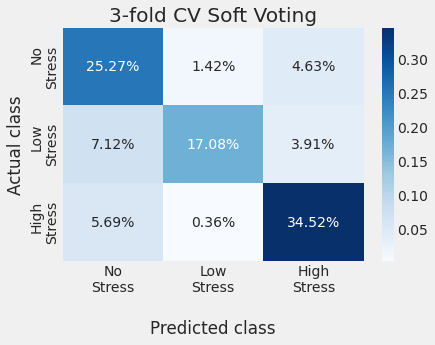

In [39]:
matrice(soft_preds, y_test,'3-fold CV Soft Voting')

## Enregistrement des modèles

In [40]:
import pickle
path= "/content/drive/MyDrive/Enseignement/ISET/Articles/Article 3/Code/Models/" 
HARD_VOTING_Combine_path = path+"HARD_VOTING_Combine_model.pickle" 
SOFT_VOTING_Combine_path = path+"SOFT_VOTING_Combine_model.pickle" 

# save models
pickle.dump(hard_voting_clf, open(HARD_VOTING_Combine_path, "wb"))
pickle.dump(soft_voting_clf, open(SOFT_VOTING_Combine_path, "wb"))